In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import os
import shutil
import cv2
import random
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import FileLink, display

2024-11-06 05:40:30.472070: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-06 05:40:30.482154: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730871630.497604   17452 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730871630.502159   17452 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 05:40:30.525062: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
sns.set(rc={'axes.facecolor': '#e9eef2'}, style='darkgrid')

In [ ]:
def delete_folder(folder_path):
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"Folder '{folder_path}' deleted successfully.")
    else:
        print(f"Folder '{folder_path}' does not exist.")


def copy_folder(src_folder, dest_folder):
    if os.path.exists(src_folder):
        try:
            shutil.copytree(src_folder, dest_folder)
            print(f"Folder '{src_folder}' copied successfully to '{dest_folder}'.")
        except FileExistsError:
            print(f"Destination folder '{dest_folder}' already exists.")
        except Exception as e:
            print(f"An error occurred: {e}")
    else:
        print(f"Source folder '{src_folder}' does not exist.")

Folder 'Brain_Cancer' deleted successfully.
Folder 'ds_copy/Brain_Cancer' copied successfully to 'Brain_Cancer'.


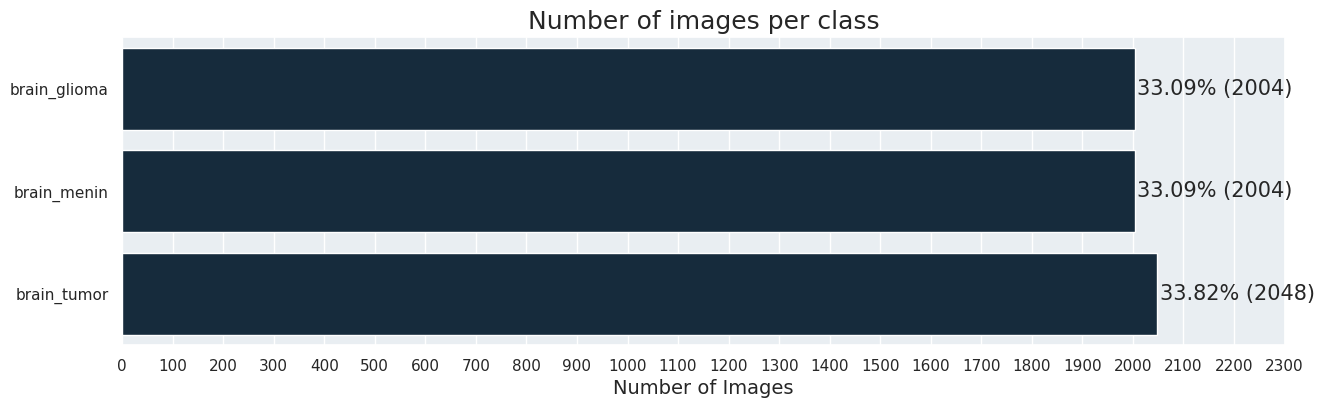

In [ ]:
# Directory where the image folders are located
base_dir = 'Brain_Cancer'

# Remove polluted dataset
delete_folder(base_dir)

# Copy the original dataset
copy_folder("ds_copy/Brain_Cancer", base_dir)

classes = [folder_name for folder_name in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, folder_name))]
counts = []
for class_name in classes:
    folder_path = os.path.join(base_dir, class_name)
    counts.append(len([file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]))
total_count = sum(counts)
if total_count > 0:
    percentages = [(count / total_count) * 100 for count in counts]
else:
    print("Error: No images found in any folder.")

plt.figure(figsize=(15, 4))
ax = sns.barplot(y=classes, x=counts, orient='h', color='#102C42')
ax.set_xticks(range(0, max(counts) + 1, 1000))

for i, p in enumerate(ax.patches):
    width = p.get_width()
    ax.text(width + 5, p.get_y() + p.get_height()/2., 
            '{:1.2f}% ({})'.format(percentages[i], counts[i]),
            va="center", fontsize=15)

# Set the x-label for the plot
plt.xlabel('Number of Images', fontsize=14)
ax.set_xticks(range(0, max(counts) + 300, 100))
# Set the title and show the plot
plt.title("Number of images per class", fontsize=18)
plt.show()

In [ ]:
heights = []
widths = []
unique_dims = set()

for class_name in classes:
    folder_path = os.path.join(base_dir, class_name)
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            # Add the dimensions (height, width, channels) to the set
            unique_dims.add((img.shape[0], img.shape[1]))
            
            # Append heights and widths for statistical calculations
            heights.append(img.shape[0])
            widths.append(img.shape[1])

# Check if all images have the same dimension
if len(unique_dims) == 1:
    print(f"All images have the same dimensions: {list(unique_dims)[0]}")
else:
    print(f"There are {len(unique_dims)} different image dimensions in the dataset.")
    print(f"Min height: {min(heights)}, Max height: {max(heights)}, Mean height: {np.mean(heights):.2f}")
    print(f"Min width: {min(widths)}, Max width: {max(widths)}, Mean width: {np.mean(widths):.2f}")

All images have the same dimensions: (512, 512)


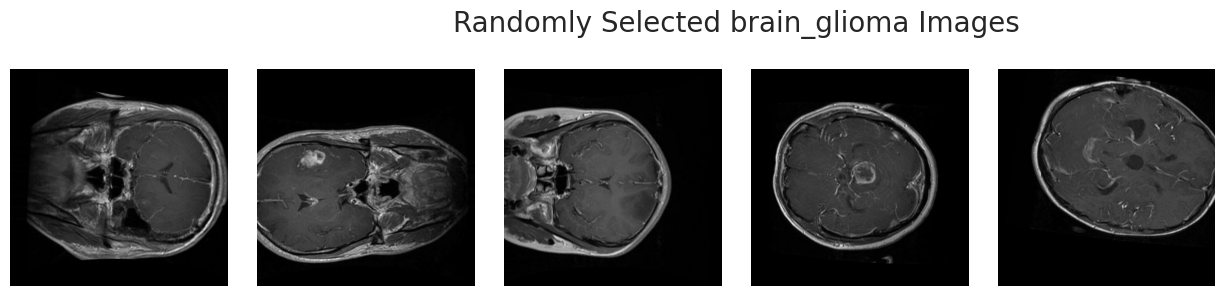

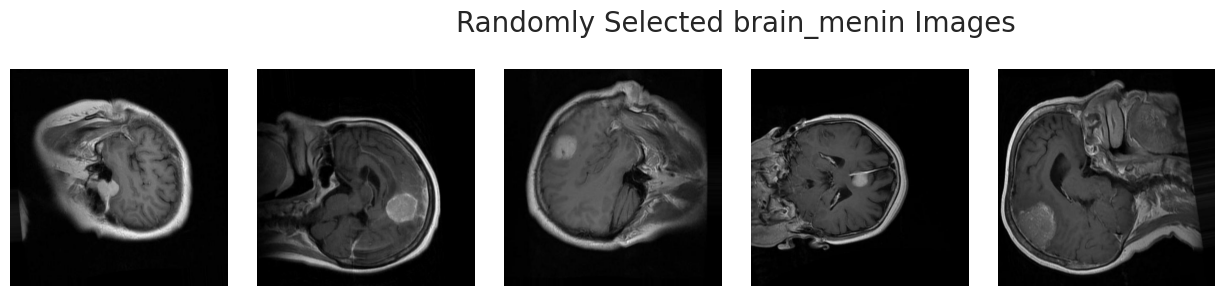

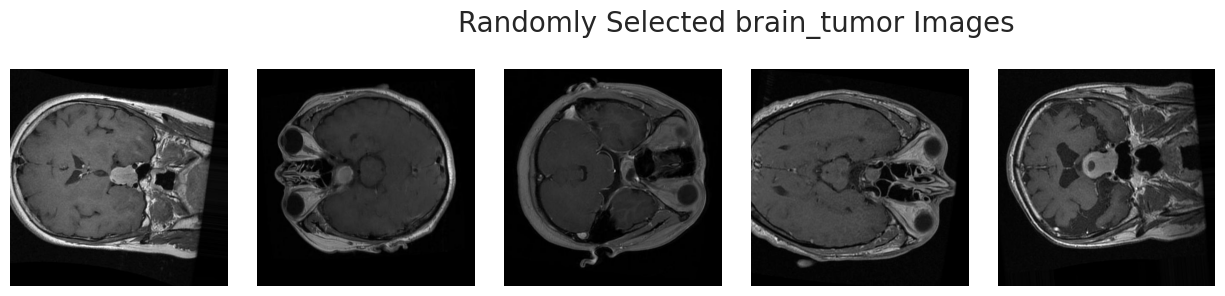

In [ ]:
# Function to plot images
def plot_images(images, title):
    plt.figure(figsize=(15, 3)) 
    for i, img_path in enumerate(images):
        plt.subplot(1, 6, i+1)  # 1x5 subplot
        img = cv2.imread(img_path)
        
        try:
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          plt.imshow(img)
        except:
           print(f"{img_path}")
        plt.axis('off')
    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()

np.random.seed(42)

for class_name in classes:
    folder_path = os.path.join(base_dir, class_name)
    all_images = [os.path.join(folder_path, file) for file in os.listdir(folder_path)]
    random_images = np.random.choice(all_images, 5, replace=False)  # Choose 6 images randomly
    plot_images(random_images, f"Randomly Selected {class_name} Images")

In [ ]:
data = []
for class_name in classes:
    folder_path = os.path.join(base_dir, class_name)
    data.extend([(os.path.join(folder_path, filename), class_name) for filename in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, filename))])

# Convert the collected data into a DataFrame
df = pd.DataFrame(data, columns=['filepath', 'label'])
df.head()

,filepath,label
0,Brain_Cancer/brain_glioma/brain_glioma_1059.jpg,brain_glioma
1,Brain_Cancer/brain_glioma/brain_glioma_0485.jpg,brain_glioma
2,Brain_Cancer/brain_glioma/brain_glioma_0537.jpg,brain_glioma
3,Brain_Cancer/brain_glioma/brain_glioma_0123.jpg,brain_glioma
4,Brain_Cancer/brain_glioma/brain_glioma_0833.jpg,brain_glioma


In [8]:
print("Total number of images:", df.shape[0])

Total number of images: 6056


In [ ]:
del data, all_images

In [ ]:
# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
print("Training data shape:", train_df.shape)
print("Validation data shape:", val_df.shape)
del df

Training data shape: (4844, 2)
Validation data shape: (1212, 2)


In [ ]:
train_df.head(10)

,filepath,label
4415,Brain_Cancer/brain_tumor/brain_tumor_1641.jpg,brain_tumor
5721,Brain_Cancer/brain_tumor/brain_tumor_1886.jpg,brain_tumor
1565,Brain_Cancer/brain_glioma/brain_glioma_1380.jpg,brain_glioma
3875,Brain_Cancer/brain_menin/brain_menin_1192.jpg,brain_menin
2758,Brain_Cancer/brain_menin/brain_menin_0348.jpg,brain_menin
5401,Brain_Cancer/brain_tumor/brain_tumor_0724.jpg,brain_tumor
5809,Brain_Cancer/brain_tumor/brain_tumor_0438.jpg,brain_tumor
4141,Brain_Cancer/brain_tumor/brain_tumor_1855.jpg,brain_tumor
5395,Brain_Cancer/brain_tumor/brain_tumor_0788.jpg,brain_tumor
5431,Brain_Cancer/brain_tumor/brain_tumor_0269.jpg,brain_tumor


In [ ]:
val_df.head(10)

,filepath,label
1186,Brain_Cancer/brain_glioma/brain_glioma_1366.jpg,brain_glioma
2327,Brain_Cancer/brain_menin/brain_menin_1098.jpg,brain_menin
130,Brain_Cancer/brain_glioma/brain_glioma_0552.jpg,brain_glioma
3803,Brain_Cancer/brain_menin/brain_menin_1288.jpg,brain_menin
5586,Brain_Cancer/brain_tumor/brain_tumor_1436.jpg,brain_tumor
3591,Brain_Cancer/brain_menin/brain_menin_1721.jpg,brain_menin
2367,Brain_Cancer/brain_menin/brain_menin_0587.jpg,brain_menin
4560,Brain_Cancer/brain_tumor/brain_tumor_1540.jpg,brain_tumor
4320,Brain_Cancer/brain_tumor/brain_tumor_0483.jpg,brain_tumor
337,Brain_Cancer/brain_glioma/brain_glioma_1090.jpg,brain_glioma


In [13]:
def add_gaussian_noise(image, mean=0, std=0.05):
    """ Add Gaussian noise to an image """
    gauss = np.random.normal(mean, std, image.shape)
    noisy_image = image + gauss
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image

In [14]:
def apply_blur(image, kernel_size=5):
    """ Apply Gaussian blur to an image """
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

In [15]:
def downsample_upsample(image, scale_percent=50):
    """ Downsample and then upsample an image """
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    return cv2.resize(resized, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_LINEAR)

In [ ]:
def count_images(dataframe):

    return dataframe.shape[0]

In [17]:
# Count and print the number of images in the training and validation sets before the modifications
total_train_images = count_images(train_df)
total_val_images = count_images(val_df)

print(f"Total number of training images: {total_train_images}")
print(f"Total number of validation images: {total_val_images}")

Total number of training images: 4844
Total number of validation images: 1212


In [ ]:
def augment_images(dataframe, base_dir):
    modified_data = []
    
    for _, row in dataframe.iterrows():
        img_path = row['filepath']
        label = row['label']
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Randomly apply one or more degradation methods
        choices = ['noise', 'blur', 'downsample']
        chosen_methods = random.sample(choices, k=random.randint(1, len(choices)))

        if 'noise' in chosen_methods:
            img = add_gaussian_noise(img)
        if 'blur' in chosen_methods:
            img = apply_blur(img)
        if 'downsample' in chosen_methods:
            img = downsample_upsample(img)

        # Save the new image with a modified name
        directory, filename = os.path.split(img_path)
        new_img_path = os.path.join(directory, f"modified_{filename}")
        cv2.imwrite(new_img_path, img)

        # Append the new image path and its label to the list
        modified_data.append((new_img_path, label))

    # Create a DataFrame with the modified images and their respective labels
    modified_images_df = pd.DataFrame(modified_data, columns=['filepath', 'label'])
    return pd.concat([dataframe, modified_images_df], ignore_index=True)

In [19]:
# Apply augmentation and update the training and validation datasets
train_df = augment_images(train_df, base_dir)
val_df = augment_images(val_df, base_dir)

In [ ]:
total_train_images = count_images(train_df)
total_val_images = count_images(val_df)

print(f"Total number of training images: {total_train_images}")
print(f"Total number of validation images: {total_val_images}")

Total number of training images: 9688
Total number of validation images: 2424


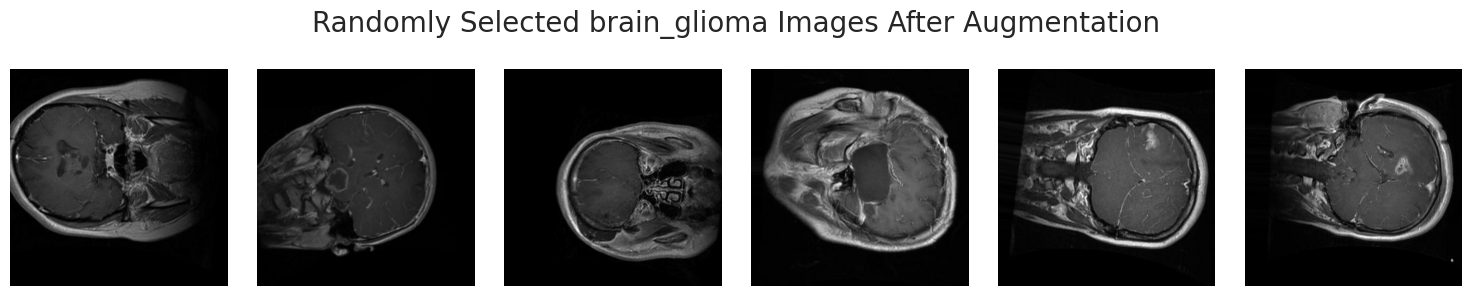

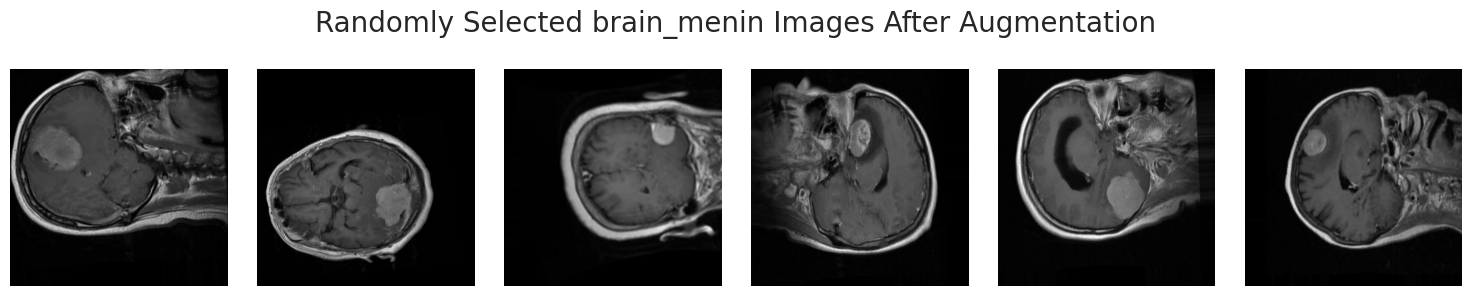

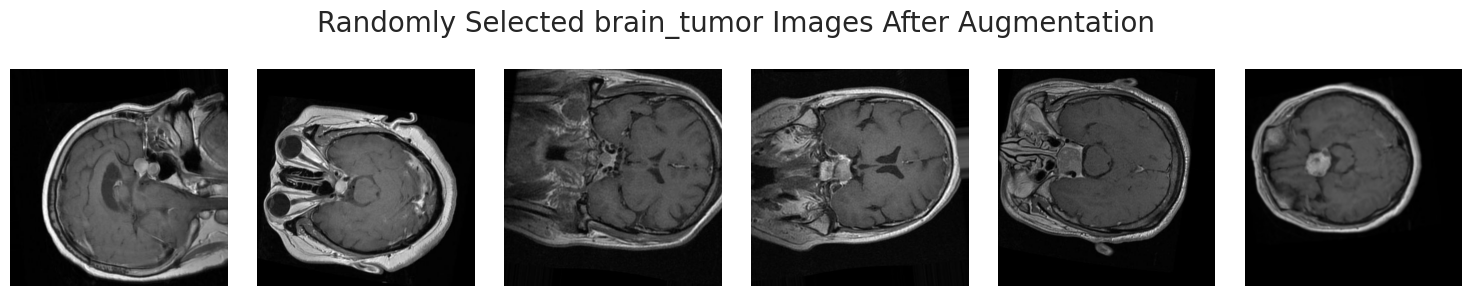

In [21]:
# Loop over each class and plot random images
for class_name in classes:
    folder_path = os.path.join(base_dir, class_name)
    all_images = [os.path.join(folder_path, file) for file in os.listdir(folder_path)]
    random_images = np.random.choice(all_images, 6, replace=False)  # Choose 6 images randomly
    plot_images(random_images, f"Randomly Selected {class_name} Images After Augmentation")

In [ ]:
def create_data_generators(train_df, val_df, preprocessing_function=None, batch_size=32, image_dimensions=(224, 224)):
    

    # Define the training data generator with appropriate augmentations
    train_datagen = ImageDataGenerator(
        rotation_range=20,                           
        width_shift_range=0.10,                      
        height_shift_range=0.10,                     
        zoom_range=0.10,                             
        horizontal_flip=True,                        
        preprocessing_function=preprocessing_function
    )

    # Define the validation data generator without any augmentations
    val_datagen = ImageDataGenerator(
        preprocessing_function=preprocessing_function
    )

    
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,                 
        x_col="filepath",                   
        y_col="label",                      
        target_size=image_dimensions,       
        batch_size=batch_size,              
        class_mode='categorical',           
        seed=42,                            
        shuffle=True                        
    )

    # Create an iterable generator for validation data
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,                   # DataFrame containing validation data
        x_col="filepath",                       
        y_col="label",
        target_size=image_dimensions,
        batch_size=batch_size,
        class_mode='categorical',           
        seed=42,
        shuffle=False                       
    )
    
    
    return train_generator, val_generator

In [ ]:
train_generator, val_generator = create_data_generators(train_df, val_df, preprocessing_function=preprocess_input)
batch_images, batch_labels = next(train_generator)
print("Shape of the first image in the batch:", batch_images[0].shape)

Found 9688 validated image filenames belonging to 3 classes.
Found 2424 validated image filenames belonging to 3 classes.
Shape of the first image in the batch: (224, 224, 3)


In [ ]:
class_indices = train_generator.class_indices
class_names = sorted(class_indices, key=class_indices.get)
class_names 

['brain_glioma', 'brain_menin', 'brain_tumor']

In [ ]:
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

I0000 00:00:1730871668.809155   17452 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [1]:
# Add custom layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  
x = Dense(4, activation='softmax')(x)  

model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

NameError: name 'GlobalAveragePooling2D' is not defined

In [27]:
plot_model(model, show_shapes=True, show_layer_names=False, dpi=200)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 25,667,076 (97.91 MB)

 Trainable params: 25,621,636 (97.74 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [ ]:
def train_model(model, train_df, val_df, preprocessing_function, image_dimensions=(224, 224), batch_size=32, num_epochs=50):
    

    # Create data generators
    train_generator, val_generator = create_data_generators(train_df, val_df, preprocessing_function, batch_size, image_dimensions)

    # Define the callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True, verbose=1)

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=num_epochs,
        validation_data=val_generator,
        validation_steps=len(val_generator),
        callbacks=[reduce_lr, early_stopping]
    )
    
    return model, history, val_generator

In [ ]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(3, activation='softmax'))  

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model, history, val_generator = train_model(model, train_df, val_df, preprocessing_function=preprocess_input, num_epochs=50)

Found 9688 validated image filenames belonging to 3 classes.
Found 2424 validated image filenames belonging to 3 classes.
Epoch 1/50


I0000 00:00:1730871684.019946   17669 service.cc:148] XLA service 0x7f87000041e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730871684.019984   17669 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2024-11-06 05:41:24.489835: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1730871686.402044   17669 cuda_dnn.cc:529] Loaded cuDNN version 90500
I0000 00:00:1730871705.983639   17669 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


303/303 ━━━━━━━━━━━━━━━━━━━━ 122s 288ms/step - accuracy: 0.5772 - loss: 2.0040 - val_accuracy: 0.3800 - val_loss: 2779.5471 - learning_rate: 0.0010
Epoch 2/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 128us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50


2024-11-06 05:43:13.410129: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-06 05:43:13.410389: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-11-06 05:43:13.432868: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


303/303 ━━━━━━━━━━━━━━━━━━━━ 66s 218ms/step - accuracy: 0.4345 - loss: 1.6395 - val_accuracy: 0.5140 - val_loss: 1.2624 - learning_rate: 0.0010
Epoch 4/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 49us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/50


2024-11-06 05:44:19.677678: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


303/303 ━━━━━━━━━━━━━━━━━━━━ 68s 223ms/step - accuracy: 0.5553 - loss: 1.3556 - val_accuracy: 0.6130 - val_loss: 6.9343 - learning_rate: 0.0010
Epoch 6/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 44us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 70s 230ms/step - accuracy: 0.6256 - loss: 1.1709 - val_accuracy: 0.5961 - val_loss: 6.3749 - learning_rate: 0.0010
Epoch 8/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 49us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 9/50


2024-11-06 05:46:37.424167: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10651073580956016031
2024-11-06 05:46:37.424210: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8416102244680310017
2024-11-06 05:46:37.430861: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


303/303 ━━━━━━━━━━━━━━━━━━━━ 70s 232ms/step - accuracy: 0.6562 - loss: 1.3335 - val_accuracy: 0.3981 - val_loss: 10.6450 - learning_rate: 0.0010
Epoch 10/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 40us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 11/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 70s 231ms/step - accuracy: 0.6882 - loss: 0.8581 - val_accuracy: 0.7541 - val_loss: 0.7759 - learning_rate: 5.0000e-04
Epoch 12/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 52us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 13/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 68s 224ms/step - accuracy: 0.7181 - loss: 0.7792 - val_accuracy: 0.7591 - val_loss: 0.7935 - learning_rate: 5.0000e-04
Epoch 14/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 39us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 15/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 69s 228ms/step - accuracy: 0.7335 - loss: 0.6964 - val_accuracy: 0.7508 - val_loss: 0.6577 - learning_rate: 5.0000e-04
Epo

2024-11-06 05:51:15.261334: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10651073580956016031
2024-11-06 05:51:15.261374: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8416102244680310017
2024-11-06 05:51:15.268654: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


303/303 ━━━━━━━━━━━━━━━━━━━━ 69s 227ms/step - accuracy: 0.7557 - loss: 0.6683 - val_accuracy: 0.6955 - val_loss: 3.0843 - learning_rate: 5.0000e-04
Epoch 18/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 43us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 19/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 70s 230ms/step - accuracy: 0.7928 - loss: 0.5639 - val_accuracy: 0.8061 - val_loss: 0.7023 - learning_rate: 5.0000e-04
Epoch 20/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 44us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 21/50


2024-11-06 05:53:34.058209: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10651073580956016031


303/303 ━━━━━━━━━━━━━━━━━━━━ 69s 228ms/step - accuracy: 0.8214 - loss: 0.4929 - val_accuracy: 0.6972 - val_loss: 0.7263 - learning_rate: 5.0000e-04
Epoch 22/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 41us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 2.5000e-04
Epoch 23/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 70s 229ms/step - accuracy: 0.8581 - loss: 0.3841 - val_accuracy: 0.7925 - val_loss: 0.5304 - learning_rate: 2.5000e-04
Epoch 24/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 43us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 2.5000e-04
Epoch 25/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 70s 230ms/step - accuracy: 0.8782 - loss: 0.3221 - val_accuracy: 0.8251 - val_loss: 0.4816 - learning_rate: 2.5000e-04
Epoch 26/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 45us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 2.5000e-04
Epoch 27/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 69s 228ms/step - accuracy: 0.8862 - loss: 0.3074 - val_accuracy: 0.9072 - val_loss: 0.3051 - learning_rate: 2.5000e-04


2024-11-06 05:59:22.297194: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10651073580956016031
2024-11-06 05:59:22.297240: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8416102244680310017


303/303 ━━━━━━━━━━━━━━━━━━━━ 70s 231ms/step - accuracy: 0.9186 - loss: 0.2335 - val_accuracy: 0.8337 - val_loss: 0.4302 - learning_rate: 2.5000e-04
Epoch 32/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 42us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 2.5000e-04
Epoch 33/50


2024-11-06 06:00:32.581536: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10651073580956016031
2024-11-06 06:00:32.587906: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


303/303 ━━━━━━━━━━━━━━━━━━━━ 69s 229ms/step - accuracy: 0.9187 - loss: 0.2256 - val_accuracy: 0.9006 - val_loss: 0.2879 - learning_rate: 2.5000e-04
Epoch 34/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 48us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 2.5000e-04
Epoch 35/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 70s 229ms/step - accuracy: 0.9242 - loss: 0.2204 - val_accuracy: 0.8965 - val_loss: 0.3122 - learning_rate: 2.5000e-04
Epoch 36/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 42us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 2.5000e-04
Epoch 37/50


2024-11-06 06:02:51.649189: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10651073580956016031


303/303 ━━━━━━━━━━━━━━━━━━━━ 70s 232ms/step - accuracy: 0.9256 - loss: 0.2119 - val_accuracy: 0.8783 - val_loss: 0.3538 - learning_rate: 2.5000e-04
Epoch 38/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 40us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 2.5000e-04
Epoch 39/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 70s 229ms/step - accuracy: 0.9361 - loss: 0.1945 - val_accuracy: 0.4158 - val_loss: 12344.3838 - learning_rate: 2.5000e-04
Epoch 40/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 43us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.2500e-04
Epoch 41/50


2024-11-06 06:05:11.595335: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10651073580956016031


303/303 ━━━━━━━━━━━━━━━━━━━━ 69s 228ms/step - accuracy: 0.9498 - loss: 0.1419 - val_accuracy: 0.9245 - val_loss: 0.1961 - learning_rate: 1.2500e-04
Epoch 42/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 55us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.2500e-04
Epoch 43/50


2024-11-06 06:06:20.746895: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10651073580956016031
2024-11-06 06:06:20.746966: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8416102244680310017


303/303 ━━━━━━━━━━━━━━━━━━━━ 70s 232ms/step - accuracy: 0.9613 - loss: 0.1131 - val_accuracy: 0.8016 - val_loss: 1708.0352 - learning_rate: 1.2500e-04
Epoch 44/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 46us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.2500e-04
Epoch 45/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 70s 230ms/step - accuracy: 0.9620 - loss: 0.1364 - val_accuracy: 0.6943 - val_loss: 1586.8986 - learning_rate: 1.2500e-04
Epoch 46/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 38us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.2500e-04
Epoch 47/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 69s 228ms/step - accuracy: 0.9649 - loss: 0.0984 - val_accuracy: 0.9538 - val_loss: 0.1202 - learning_rate: 1.2500e-04
Epoch 48/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 44us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.2500e-04
Epoch 49/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 70s 231ms/step - accuracy: 0.9635 - loss: 0.1028 - val_accuracy: 0.8849 - val_loss: 0.3224 - learning_rate: 1.250

In [ ]:
def plot_learning_curves(history, start_epoch=5):
    

    # Convert the history.history dict to a pandas DataFrame
    df = pd.DataFrame(history.history)

    # Plot the curves from the specified epoch onwards
    df = df.iloc[start_epoch-1:]

    sns.set(rc={'axes.facecolor': '#f0f0fc'}, style='darkgrid')

    # Plotting the learning curves
    plt.figure(figsize=(15,6))

    # Plotting the training and validation loss
    plt.subplot(1, 2, 1)
    sns.lineplot(x=df.index, y=df['loss'], color='#102C42', label='Train Loss')
    sns.lineplot(x=df.index, y=df['val_loss'], color='orangered', linestyle='--', label='Validation Loss')
    plt.title('Loss Evolution')

    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    sns.lineplot(x=df.index, y=df['accuracy'], color='#102C42', label='Train Accuracy')
    sns.lineplot(x=df.index, y=df['val_accuracy'], color='orangered', linestyle='--', label='Validation Accuracy')
    plt.title('Accuracy Evolution')

    plt.show()

In [ ]:
#plot_learning_curves(history)

ValueError: All arrays must be of the same length

In [ ]:
def evaluate_model_performance(model, val_generator, class_labels):
    
    
   
    true_labels = val_generator.classes

    class_labels = list(val_generator.class_indices.keys())

    predictions = model.predict(val_generator, steps=len(val_generator))
    
    predicted_labels = np.argmax(predictions, axis=1)
    
    true_labels = val_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')
    
    colors = ["white", "#102C42"]
    cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step
              precision    recall  f1-score   support

brain_glioma       1.00      0.95      0.97       802
 brain_menin       0.92      0.95      0.94       802
 brain_tumor       0.94      0.96      0.95       820

    accuracy                           0.95      2424
   macro avg       0.95      0.95      0.95      2424
weighted avg       0.95      0.95      0.95      2424





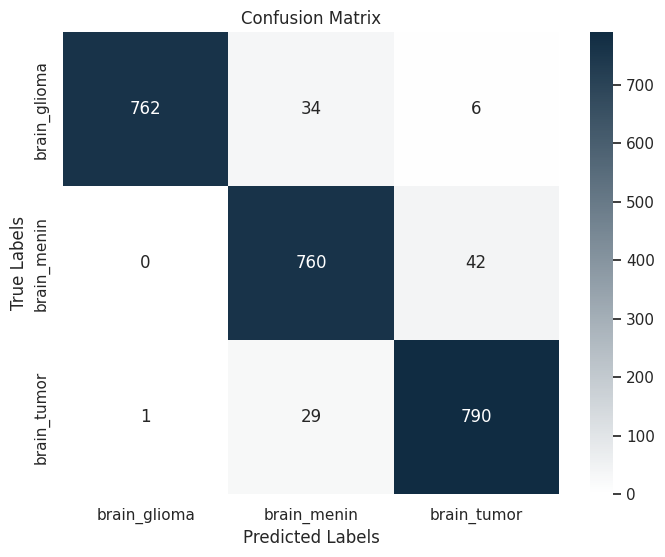

In [35]:
evaluate_model_performance(model, val_generator, classes)

In [36]:
# Save the entire ResNet50V2 model
model.save('ResNet50V2_model.h5')